## Anomaly Score 받아오기

In [131]:
# argument
dataset_type = 'multi'

In [132]:
import numpy as np
import pandas as pd

ano_score = np.load(f'save/{dataset_type}_class/1_26_efficientnet_b6/det_mult_anomaly_scores.npy')
print(len(ano_score))

2228


## Label 값 받아오기

In [133]:
DATASET_PATH = f'/tf/KAIER_2022/Battery_data/{dataset_type}_class'

from glob import glob
import os
def get_label():
    mode = 'test'
    
    if dataset_type == 'multi':
        normal_names = ['코팅부 경계부 불량', '무지부 줄무늬', '코팅부 접힘', '코팅부 미코팅', '코팅부 줄무늬', '코팅부 테이프', \
                     '코팅부 기재연결부', '무지부 기재연결부', '코팅부 코팅불량']
        abnormal_names = ['코팅부 버블', '코팅부 흑점', '무지부 주름', '코팅부 찍힘', '코팅부 백점', '코팅부 라벨지']
    elif dataset_type == 'one':
        normal_names = ['코팅부 경계부 불량']
        abnormal_names = ['무지부 줄무늬', '코팅부 접힘', '코팅부 미코팅', '코팅부 줄무늬', '코팅부 테이프', \
                     '코팅부 기재연결부', '무지부 기재연결부', '코팅부 코팅불량', '코팅부 버블', '코팅부 흑점', '무지부 주름', '코팅부 찍힘', '코팅부 백점', '코팅부 라벨지']

#     normal_paths = []
#     for name in normal_names:
#         fpattern = os.path.join(DATASET_PATH, f'{mode}/{name}/*.bmp')
#         fpaths = sorted(glob(fpattern))
# #         print(len(fpaths))
#         normal_paths += fpaths
    
#     abnormal_paths = []
#     for name in abnormal_names:
#         fpattern = os.path.join(DATASET_PATH, f'{mode}/{name}/*.bmp')
#         fpaths = sorted(glob(fpattern))
# #         print(len(fpaths))
#         abnormal_paths += fpaths

    fpattern = os.path.join(DATASET_PATH, f'{mode}/*/*.bmp')
    fpaths = sorted(glob(fpattern))
    
    # get only label name in data path 
    def split(x):
        return x.split('/')[-2]    

    test_class_list = list(map(split, fpaths))
    
    def change_name_to_label(x):
        if x in normal_names:
            return 0
        else:
            return 1

    test_label_list = list(map(change_name_to_label, test_class_list))

    return test_label_list, test_class_list

In [134]:
label, classes = get_label()
# print(label)

In [135]:
np.unique(label, return_counts=True)

(array([0, 1]), array([2160,   68]))

In [136]:
len(ano_score)

2228

In [137]:
# AUROC 확인
from sklearn.metrics import roc_auc_score
print(roc_auc_score(label, ano_score))

0.9616489651416122


In [138]:
# Anomaly Score 확인
print(ano_score)

[1418.65162758 1423.41538399 1013.66748037 ... 1280.06969166 1038.72947666
  989.6428418 ]


In [139]:
print(max(ano_score))

5920.335999141389


## Threshold 잡기

max(tpr_fpr)가 되는 지점의 threshold

In [140]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(label, ano_score)
J = tpr-fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]


print("index : ", ix)
print("Best Threshold: ", best_thresh)
print("tpr: ", tpr[ix])
print("fpr: ", fpr[ix])

index :  86
Best Threshold:  929.5098511497685
tpr:  0.9558823529411765
fpr:  0.08888888888888889


## ROC Curve

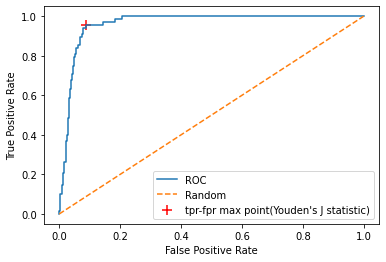

In [141]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label = "ROC")
plt.scatter(fpr[ix], tpr[ix], marker = '+', s = 100, color = 'r', label = "tpr-fpr max point(Youden's J statistic)")
# plt.scatter(fpr[103], tpr[103], marker = '+', s = 100, color = 'black', label = 'fpr 0.2 point')
plt.plot([0.0, 1.0], [0.0, 1.0], '--', label = "Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [142]:
# Threshold를 반영한 예측값
pred = ano_score > best_thresh
print(pred)

[ True  True  True ...  True  True  True]


In [143]:
pred = list(map(int, pred))

In [144]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score
import scikitplot as skplt 

accuracy score: 0.9120287253141831
recall: 0.9411764705882353
preicision: 0.25


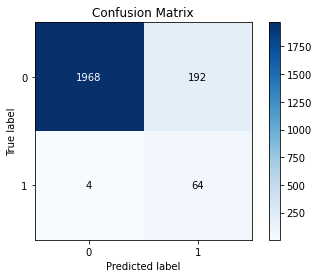

In [146]:
skplt.metrics.plot_confusion_matrix(y_true=label,y_pred=pred)
# plt.savefig(os.path.join(test_score_path, 'confusion_matrix.png'))
print("accuracy score: {}" .format(accuracy_score(label, pred)))
print("recall: {}" .format(recall_score (label, pred)))
print("preicision: {}" .format(precision_score(label, pred)))

In [147]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(label, pred)
print(matrix)

TN = matrix[0][0]
FP = matrix[0][1]
FN = matrix[1][0]
TP = matrix[1][1]

print("False Negative, 이상을 정상으로 예측한 경우: ", FN, "건")
print("True Negative, 정상을 정상으로 예측한 경우: ", TN, "건")
print("False Positive, 정상을 이상으로 예측한 경우: ", FP, "건")
print("True Positive, 이상을 이상으로 예측한 경우: ", TP, "건")

[[1968  192]
 [   4   64]]
False Negative, 이상을 정상으로 예측한 경우:  4 건
True Negative, 정상을 정상으로 예측한 경우:  1968 건
False Positive, 정상을 이상으로 예측한 경우:  192 건
True Positive, 이상을 이상으로 예측한 경우:  64 건


In [148]:
def check_false(pred,label, type_='positive'):
    if type_ == 'positive':
        _idx = np.where((np.array(pred)==1)&(np.array(label)==0))[0]
    else:
        _idx = np.where((np.array(pred)==0)&(np.array(label)==1))[0]
    
    print("false {}: {}" .format(type_, len(_idx)))
    
    false_unique = np.unique(np.array(classes)[_idx], return_counts=True)
    false_cls_name = false_unique[0]
    false_count = false_unique[1]
    
    return pd.DataFrame({'class':false_cls_name, 'count':false_count}).sort_values(by=['count'], ascending=False)

In [156]:
false_df = check_false(pred, label, type_='positive')

false positive: 192


In [157]:
false_df

,class,count
1,무지부 줄무늬,72
8,코팅부 테이프,41
2,코팅부 경계부 불량,29
4,코팅부 미코팅,18
0,무지부 기재연결부,14
7,코팅부 코팅불량,8
5,코팅부 접힘,7
3,코팅부 기재연결부,2
6,코팅부 줄무늬,1


In [151]:
fp_idx = np.where((np.array(pred)==1)&(np.array(label)==0))[0]

In [152]:
fp_unique = np.unique(np.array(classes)[fp_idx], return_counts=True)
fp_cls_name = fp_unique[0]
fp_count = fp_unique[1]

In [153]:
pd.DataFrame({'class':fp_cls_name, 'count':fp_count}).sort_values(by=['count'], ascending=False)

,class,count
1,무지부 줄무늬,72
8,코팅부 테이프,41
2,코팅부 경계부 불량,29
4,코팅부 미코팅,18
0,무지부 기재연결부,14
7,코팅부 코팅불량,8
5,코팅부 접힘,7
3,코팅부 기재연결부,2
6,코팅부 줄무늬,1


## visualize anomaly score

In [154]:
ano_score[np.array(label)==0]

array([1418.65162758, 1423.41538399, 1013.66748037, ..., 1593.84169704,
        897.23784236, 3841.49383481])

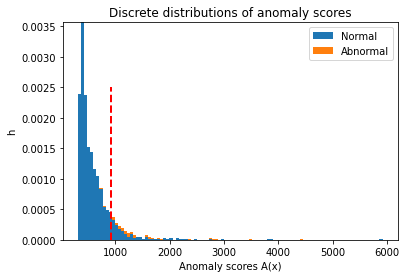

In [159]:
plt.hist([ano_score[np.array(label) == 0], ano_score[np.array(label) == 1]],
          bins=100, density=True, stacked=True,
          label=["Normal", "Abnormal"])
plt.title("Discrete distributions of anomaly scores")
plt.xlabel("Anomaly scores A(x)")
plt.ylabel("h")
plt.legend()
plt.vlines(best_thresh, 0, 0.0025, color='red', linestyle='--', linewidth=2)
plt.show()

In [18]:
Pre_cision = TP / (TP+FP)
Re_call = TP / (TP + FN)
Accu_racy = (TP + TN) / (TP + FN + FP + TN)

print("Precision: ", Pre_cision)
print("Recall : ", Re_call)
print("Accuracy: ", Accu_racy)

Precision:  0.2090032154340836
Recall :  0.9558823529411765
Accuracy:  0.8882405745062837


In [45]:
#                예측 N(정상)    예측 P(이상)
# 실제 N(정상)  True Negative    False Positive
# 실제 P(이상)  False Negative   True Positive

# True Positive Rate = TP / (FN + TP) : 제대로 예측한 positive / 실제 positive, 실제 이상 이미지 중 얼마나 많이 잡아냈느냐
# False Positive Rate = FP / (TN + FP) : 정상인데 이상으로 예측한 것 / 실제 negative, 실제 정상 이미지 중 이상으로 예측한 비율

In [101]:
DATASET_PATH = '/workspace/CAMPUS/TOFU_Box/'

mode = 'test'
fpattern1 = os.path.join(DATASET_PATH,  f'{mode}/NG/*/*.jpg')
fpaths1 = sorted(glob(fpattern1))

fpattern2 = os.path.join(DATASET_PATH,  f'{mode}/OK/*/*.jpg')
fpaths2 = sorted(glob(fpattern2))

print(len(fpaths1))
print(len(fpaths2))

550
400


## 이상인데 (Positive) 정상(Normal) 으로 예측한 것(False Negative) 확인

In [103]:
# [:550] 까지는 모두 이상인 데이터임.
FN_list = []
cnt = 0
for index, p in enumerate(pred[:550]):
    if p == False:
        cnt += 1
        print("index: ", index, "count: ", cnt, "FN data: ", fpaths1[index])
        FN_list.append(index)
    

index:  10 count:  1 FN data:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153700560285.jpg
index:  14 count:  2 FN data:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153800050467.jpg
index:  48 count:  3 FN data:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153800450814.jpg
index:  64 count:  4 FN data:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-154000180378.jpg
index:  67 count:  5 FN data:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-154000280381.jpg
index:  70 count:  6 FN data:  /workspace/CAMPUS/TOFU_Box/test/NG/머리카락/2020-11-29-141700060813.jpg
index:  71 count:  7 FN data:  /workspace/CAMPUS/TOFU_Box/test/NG/머리카락/2020-11-29-141700090720.jpg
index:  72 count:  8 FN data:  /workspace/CAMPUS/TOFU_Box/test/NG/머리카락/2020-11-29-141700190565.jpg
index:  73 count:  9 FN data:  /workspace/CAMPUS/TOFU_Box/test/NG/머리카락/2020-11-29-141700220752.jpg
index:  74 count:  10 FN data:  /workspace/CAMPUS/TOFU_Box/test/NG/머리카락/2020-11-29-141700240968.jpg
index:  76 count:  

In [104]:
print(FN_list)

[10, 14, 48, 64, 67, 70, 71, 72, 73, 74, 76, 79, 80, 82, 83, 85, 86, 87, 90, 93, 94, 95, 96, 97, 98, 100, 101, 103, 106, 108, 109, 110, 111, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 125, 126, 127, 129, 130, 132, 133, 134, 135, 137, 138, 139, 173, 174, 190, 201, 220, 222, 234, 236, 245, 276, 340, 341, 343, 345, 346, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 361, 362, 364, 366, 367, 368, 369, 370, 371, 373, 375, 378, 379, 380, 382, 384, 386, 387, 388, 389, 393, 395, 396, 397, 398, 399, 400, 403, 404, 409, 415, 418, 420, 424, 436, 443, 461, 462, 468, 485, 524]


In [105]:
# False Negative인 애들 anomaly score 값 저장하기
FN_score = []
for fn_idx in FN_list:
    print("FN Anomaly score: ", ano_score[fn_idx], "index: ", fn_idx, "image:", fpaths1[fn_idx])
    FN_score.append(ano_score[fn_idx])


FN Anomaly score:  797.2254558429365 index:  10 image: /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153700560285.jpg
FN Anomaly score:  2895.953906060022 index:  14 image: /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153800050467.jpg
FN Anomaly score:  2076.192149534414 index:  48 image: /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153800450814.jpg
FN Anomaly score:  2690.8894775451045 index:  64 image: /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-154000180378.jpg
FN Anomaly score:  2856.8822177589755 index:  67 image: /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-154000280381.jpg
FN Anomaly score:  2848.0512828419187 index:  70 image: /workspace/CAMPUS/TOFU_Box/test/NG/머리카락/2020-11-29-141700060813.jpg
FN Anomaly score:  1104.5136812183264 index:  71 image: /workspace/CAMPUS/TOFU_Box/test/NG/머리카락/2020-11-29-141700090720.jpg
FN Anomaly score:  470.8380560452497 index:  72 image: /workspace/CAMPUS/TOFU_Box/test/NG/머리카락/2020-11-29-141700190565.jpg
FN Anomaly score:  923

In [106]:
FN_score.sort(reverse = True)
print(FN_score)

[2989.307186886901, 2955.5353428928647, 2931.187265526387, 2895.953906060022, 2856.8822177589755, 2848.0512828419187, 2815.1485005154973, 2806.0497203804553, 2775.8710177192697, 2752.824470985215, 2690.8894775451045, 2538.5685315879236, 2536.2708940189186, 2536.042915685005, 2494.345447552701, 2486.3795221515466, 2442.320863665198, 2372.0694778971956, 2360.646206033096, 2326.4630162012763, 2275.267100139172, 2260.039626029048, 2248.3913357447163, 2227.9050920881564, 2224.280314141729, 2222.385424399632, 2188.041059464158, 2168.4733960637823, 2076.192149534414, 2051.974896384927, 2022.5601205112616, 1978.6530642622383, 1967.439003168547, 1905.5082267506223, 1890.561412281444, 1868.9218019180698, 1852.2072290182987, 1851.7472104838816, 1815.9659460166731, 1804.468777095472, 1765.5170317488592, 1742.91306585056, 1714.4447711274647, 1700.0145098997746, 1646.652327446628, 1622.9418619010394, 1608.6801000097187, 1601.5107826664607, 1493.0780848655122, 1477.7471580929705, 1469.4808587270309, 

## 정상인데 (Negative) 이상으로 예측된 경우 (False Positive)

In [107]:
# [550:] 까지는 모두 정상인 데이터임.
FP_list = []
cnt = 0
for index, p in enumerate(pred[550:]):
    if p == True:
        cnt += 1
        print("index: ", index+550, "count: ", cnt, "image: ", fpaths2[index])
        FP_list.append(index+550)
    

index:  559 count:  1 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-24-133900460072.jpg
index:  652 count:  2 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-24-134200030380.jpg
index:  720 count:  3 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-29-113800360468.jpg
index:  734 count:  4 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-29-113900200941.jpg
index:  750 count:  5 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상B/2020-11-24-131600520464.jpg
index:  774 count:  6 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상B/2020-11-24-133300520173.jpg
index:  776 count:  7 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상B/2020-11-24-133300590860.jpg
index:  779 count:  8 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상B/2020-11-24-133400010625.jpg
index:  790 count:  9 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상B/2020-11-24-133500290359.jpg
index:  795 count:  10 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상B/2020-11-24-133600060804.jpg
index:  815 count:  11 image:

In [33]:
print(FP_list)

[591, 712, 719, 720, 734, 738, 739, 766, 770, 772, 774, 775, 778, 779, 780, 781, 790, 794, 795, 797, 808, 814, 815, 820, 837, 847, 852, 854, 879, 884, 901, 907, 909, 921, 923, 924, 925, 930, 936, 939, 942, 947]


In [34]:
# False Negative인 애들 anomaly score 값 저장하기
FP_score = []
for fn_idx in FP_list:
    print("FP Anomaly score: ", ano_score[fn_idx], "index: ", fn_idx, "image: ", fpaths2[fn_idx-550])
    FP_score.append(ano_score[fn_idx])


FP Anomaly score:  8251.24910324812 index:  591 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-24-134000150468.jpg
FP Anomaly score:  17839.442697471008 index:  712 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-29-113800190658.jpg
FP Anomaly score:  6015.349350051643 index:  719 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-29-113800350939.jpg
FP Anomaly score:  22048.573624121957 index:  720 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-29-113800360468.jpg
FP Anomaly score:  14960.126290889457 index:  734 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-29-113900200941.jpg
FP Anomaly score:  6871.024883223336 index:  738 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-29-113900320032.jpg
FP Anomaly score:  8576.873877353655 index:  739 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-29-113900330899.jpg
FP Anomaly score:  8790.525978404912 index:  766 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상B/2020-11-24-133300150776.jpg
FP Ano

In [35]:
FP_score.sort(reverse = True)
print(FP_score)

[22048.573624121957, 21153.533833313966, 19031.737411486603, 17839.442697471008, 14960.126290889457, 14822.36756852828, 13971.024202106986, 13248.93567936619, 12641.34503210336, 12053.118268344551, 11832.823109586956, 11091.83946076408, 9899.5741333802, 9377.303194614826, 8904.999617261812, 8790.525978404912, 8576.873877353655, 8496.584339691326, 8465.880032366607, 8453.586842928082, 8438.398766620317, 8274.138983940938, 8251.24910324812, 8119.492801309874, 8081.419512911699, 7944.71329748712, 7766.351481130463, 7743.869719389826, 7743.4987060951535, 7139.115717173321, 7072.099595056848, 7043.907553559789, 6988.667533686385, 6887.964148453437, 6871.024883223336, 6696.632095174398, 6458.853207917107, 6412.384691959247, 6373.843059917272, 6293.973277020993, 6225.8631347138435, 6015.349350051643]


## 이상인데 이상으로 판단한 경우(True Positive)

In [36]:
# [:550] 까지는 모두 이상인 데이터임.
TP_list = []
for index, p in enumerate(pred[:550]):
    if p == True:
        print("index: ", index)
        TP_list.append(index)
    

index:  0
index:  1
index:  2
index:  3
index:  4
index:  5
index:  6
index:  7
index:  8
index:  9
index:  11
index:  12
index:  13
index:  14
index:  15
index:  16
index:  17
index:  18
index:  19
index:  20
index:  21
index:  22
index:  23
index:  24
index:  25
index:  26
index:  27
index:  28
index:  29
index:  30
index:  31
index:  32
index:  33
index:  34
index:  35
index:  36
index:  37
index:  38
index:  39
index:  40
index:  41
index:  42
index:  43
index:  44
index:  45
index:  46
index:  47
index:  48
index:  49
index:  50
index:  51
index:  52
index:  53
index:  54
index:  55
index:  56
index:  57
index:  58
index:  59
index:  60
index:  61
index:  62
index:  63
index:  64
index:  65
index:  66
index:  68
index:  69
index:  70
index:  71
index:  74
index:  75
index:  76
index:  77
index:  78
index:  79
index:  80
index:  81
index:  82
index:  83
index:  84
index:  86
index:  87
index:  89
index:  90
index:  91
index:  92
index:  93
index:  94
index:  95
index:  96
index:  9

In [65]:
print(TP_list)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 78, 79, 81, 83, 84, 86, 88, 89, 90, 91, 92, 93, 95, 96, 98, 99, 102, 104, 105, 107, 108, 112, 113, 114, 117, 118, 119, 120, 122, 123, 124, 126, 128, 131, 135, 136, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 246, 247, 248, 249, 250, 251, 252, 

In [66]:
# True Positive인 애들 anomaly score 값 저장하기
TP_score = []
for idx in TP_list:
    print("TP Anomaly score: ", ano_score[idx], "index: ", idx, "image: ", fpaths1[idx])
    TP_score.append(ano_score[idx])


TP Anomaly score:  3974.613883417973 index:  0 image:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153700430393.jpg
TP Anomaly score:  19705.21028649062 index:  1 image:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153700480726.jpg
TP Anomaly score:  14929.092516615521 index:  2 image:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153700490135.jpg
TP Anomaly score:  44833.11035246216 index:  3 image:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153700490655.jpg
TP Anomaly score:  11959.611392053775 index:  4 image:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153700500466.jpg
TP Anomaly score:  7629.164235201292 index:  5 image:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153700520507.jpg
TP Anomaly score:  10129.50240821143 index:  6 image:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153700520925.jpg
TP Anomaly score:  10540.19294463305 index:  7 image:  /workspace/CAMPUS/TOFU_Box/test/NG/금속/2020-11-29-153700530615.jpg
TP Anomaly score:  27995.22881

In [67]:
TP_score.sort(reverse = True)
print(TP_score)

[111525.60733040981, 78655.97655953218, 64565.60044147074, 63548.39068527892, 61133.07817997411, 59411.673543149605, 57152.52662371658, 52482.455746416, 51976.12677703053, 49266.155681326985, 47124.18282338977, 46612.77731729547, 46520.59305048734, 46272.83395475149, 46067.11633114144, 44833.11035246216, 44405.965437188745, 43508.79534860188, 42812.65003381048, 40767.78874844313, 40483.15003249096, 40243.34838002175, 39631.22328083217, 38541.807783614844, 38269.54649236501, 37862.42977851513, 37362.360762029886, 36650.915112673436, 36576.92499453155, 36341.64962104149, 35935.03962730368, 35543.68581279181, 35467.29284623265, 35200.60821208855, 35158.63156992826, 34728.756761611956, 34633.93821447436, 34526.100414987886, 34222.350330058485, 34138.15875775367, 33998.39473827183, 31200.591124027964, 30990.12147827364, 30712.252622873755, 30439.125405952334, 30352.510255986825, 30224.23089243937, 29865.362911707827, 29628.895504731685, 29528.53490273158, 29459.473086058395, 29002.478869509

## True Negative (정상인데 정상으로 판단한 경우)

In [68]:
# [550:] 까지는 모두 이상인 데이터임.
TN_list = []
for index, p in enumerate(pred[550:]):
    if p == False:
        print("index: ", index+550)
        TN_list.append(index+550)
    

index:  550
index:  551
index:  552
index:  553
index:  554
index:  555
index:  556
index:  557
index:  558
index:  560
index:  561
index:  562
index:  563
index:  564
index:  565
index:  566
index:  567
index:  568
index:  569
index:  570
index:  571
index:  572
index:  573
index:  574
index:  575
index:  576
index:  578
index:  579
index:  581
index:  582
index:  584
index:  585
index:  586
index:  587
index:  588
index:  589
index:  590
index:  592
index:  593
index:  594
index:  595
index:  596
index:  597
index:  598
index:  599
index:  600
index:  601
index:  602
index:  603
index:  604
index:  605
index:  606
index:  607
index:  608
index:  609
index:  610
index:  611
index:  612
index:  613
index:  614
index:  615
index:  616
index:  617
index:  618
index:  619
index:  620
index:  621
index:  622
index:  623
index:  624
index:  625
index:  626
index:  627
index:  628
index:  629
index:  630
index:  631
index:  632
index:  633
index:  634
index:  635
index:  636
index:  637
inde

In [69]:
print(TN_list)

[550, 551, 552, 553, 554, 555, 556, 557, 558, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 578, 579, 581, 582, 584, 585, 586, 587, 588, 589, 590, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 713, 714, 716, 717, 718, 719, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 748, 749, 751, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 764,

In [70]:
# True Positive인 애들 anomaly score 값 저장하기
TN_score = []
for idx in TN_list:
    print("TN Anomaly score: ", ano_score[idx], "index: ", idx, "image: ", fpaths2[idx-550])
    TN_score.append(ano_score[idx])

TN Anomaly score:  176.12712568352435 index:  550 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-24-133900350125.jpg
TN Anomaly score:  351.7693046524146 index:  551 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-24-133900350732.jpg
TN Anomaly score:  208.49487607177798 index:  552 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-24-133900360241.jpg
TN Anomaly score:  102.27590845157556 index:  553 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-24-133900360837.jpg
TN Anomaly score:  162.1974991821553 index:  554 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-24-133900370430.jpg
TN Anomaly score:  330.8086011168598 index:  555 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-24-133900380030.jpg
TN Anomaly score:  880.2924588014637 index:  556 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-24-133900420811.jpg
TN Anomaly score:  124.77748810054982 index:  557 image:  /workspace/CAMPUS/TOFU_Box/test/OK/정상A/2020-11-24-133900430415.jpg
TN A

In [71]:
TN_score.sort(reverse = True)
print(TN_score)

[1303.7842614665205, 1290.0845946581976, 1285.2624409072887, 1284.735608044686, 1276.4904701392225, 1263.4208228962452, 1262.55385963757, 1257.930692449183, 1251.8228238160568, 1250.8350758026354, 1244.1665495655498, 1243.5141323200078, 1230.6601974822697, 1227.925517064985, 1219.3828409364603, 1185.6141914580949, 1163.6435076845592, 1143.8027559759066, 1131.1185574500414, 1120.6959438918857, 1107.6458985238787, 1095.3676082240418, 1089.4141863928526, 1079.6123927653534, 1071.0509058973985, 1062.338474111486, 1059.356380295707, 1054.1396180377226, 1043.2128659117734, 1042.553076703567, 1036.2051316178768, 1035.6576224958917, 1021.4316402828699, 1012.7691396378796, 996.6709210440167, 980.0872398340143, 978.8645572934474, 976.4536945931613, 973.6249096723137, 966.6662457583152, 964.0517346209148, 963.9183863217477, 963.1973331701657, 953.1683349876355, 951.2793203304657, 949.6086303194897, 941.9074202975025, 929.5366523987225, 916.8060916322138, 910.3826843147981, 882.6524723187104, 880.

## 실제 이미지 데이터 확인하기

In [15]:
DATASET_PATH = '/workspace/CAMPUS/TOFU_data_20p_trim/'

mode = 'test'
fpattern1 = os.path.join(DATASET_PATH,  f'{mode}/NG/*/*.jpg')
fpaths1 = sorted(glob(fpattern1))

fpattern2 = os.path.join(DATASET_PATH,  f'{mode}/OK/*/*.jpg')
fpaths2 = sorted(glob(fpattern2))

print(len(fpaths1))
print(len(fpaths2))

550
400


In [66]:
print(len(os.listdir(os.path.join(DATASET_PATH, "test", "OK", "정상B"))))
print(len(os.listdir(os.path.join(DATASET_PATH, "test", "OK", "정상A"))))
#os.rmdir(os.path.join(DATASET_PATH, "train", "OK", ".ipynb_checkpoints"))

200
200


In [50]:
import os

print(os.listdir(os.path.join(DATASET_PATH, "test", "NG")))


#os.rmdir(os.path.join(DATASET_PATH, "test", "NG", ".ipynb_checkpoints"))

['머리카락', '상단불량D', '탄화물', '금속', '플라스틱', '유바', '상단불량E', '벌레']


In [54]:
print(len(os.listdir(os.path.join(DATASET_PATH, "test", "NG", "머리카락"))))
print(len(os.listdir(os.path.join(DATASET_PATH, "test", "NG", "상단불량D"))))
print(len(os.listdir(os.path.join(DATASET_PATH, "test", "NG", "탄화물"))))
print(len(os.listdir(os.path.join(DATASET_PATH, "test", "NG", "금속"))))
print(len(os.listdir(os.path.join(DATASET_PATH, "test", "NG", "플라스틱"))))
print(len(os.listdir(os.path.join(DATASET_PATH, "test", "NG", "유바"))))
print(len(os.listdir(os.path.join(DATASET_PATH, "test", "NG", "상단불량E"))))
print(len(os.listdir(os.path.join(DATASET_PATH, "test", "NG", "벌레"))))

70
50
70
70
70
70
80
70
